In [1]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import pandas as pd

import sys
import os
sys.path.append(os.path.abspath(".."))

from src.modeling_utils import * 


In [2]:
data = pd.read_csv('../data/data_balita.csv')
data.head() 

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,laki-laki,44.591973,stunted
1,0,laki-laki,56.705203,tinggi
2,0,laki-laki,46.863358,normal
3,0,laki-laki,47.508026,normal
4,0,laki-laki,42.743494,severely stunted


- Umur (Bulan): Mengindikasikan usia balita dalam bulan. Rentang usia ini penting untuk menentukan fase pertumbuhan anak dan membandingkannya dengan standar pertumbuhan yang sehat.

- Jenis Kelamin: Terdapat dua kategori dalam kolom ini, 'laki-laki' dan 'perempuan'. Jenis kelamin merupakan faktor penting dalam analisis pola pertumbuhan dan risiko stunting.

- Tinggi Badan: Dicatat dalam centimeter, tinggi badan adalah indikator utama untuk menilai pertumbuhan fisik balita. Data ini memungkinkan peneliti untuk menentukan apakah pertumbuhan anak sesuai dengan standar usianya.

- Status Gizi: Kolom ini dikategorikan menjadi 4 status - 'severely stunting', 'stunting', 'normal', dan 'tinggi'. 'Severely stunting' menunjukkan kondisi sangat serius, 'stunting' menunjukkan kondisi stunting, 'normal' mengindikasikan status gizi yang sehat, dan 'tinggi' menunjukkan pertumbuhan di atas rata-rata. Kategori ini membantu dalam identifikasi cepat dan intervensi bagi anak-anak yang berisiko atau mengalami masalah pertumbuhan.

In [3]:
data['Jenis Kelamin'] = data['Jenis Kelamin'].map({"perempuan":0, "laki-laki":1})


In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Status Gizi'] = le.fit_transform(data['Status Gizi'])

In [5]:
print(le.classes_)

['normal' 'severely stunted' 'stunted' 'tinggi']


In [6]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,1,44.591973,2
1,0,1,56.705203,3
2,0,1,46.863358,0
3,0,1,47.508026,0
4,0,1,42.743494,1
...,...,...,...,...
120994,60,0,100.600000,0
120995,60,0,98.300000,2
120996,60,0,121.300000,0
120997,60,0,112.200000,0


In [7]:
data['Jenis Kelamin'].value_counts()

Jenis Kelamin
0    61002
1    59997
Name: count, dtype: int64

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Umur (bulan),120999.0,30.173803,17.575119,0.000000,15.0,30.0,45.0,60.0
Jenis Kelamin,120999.0,0.495847,0.499985,0.000000,0.0,0.0,1.0,1.0
Tinggi Badan (cm),120999.0,88.655434,17.300997,40.010437,77.0,89.8,101.2,128.0
Status Gizi,120999.0,0.877520,1.142700,0.000000,0.0,0.0,2.0,3.0


In [9]:
data['Status Gizi'].value_counts()

Status Gizi
0    67755
1    19869
3    19560
2    13815
Name: count, dtype: int64

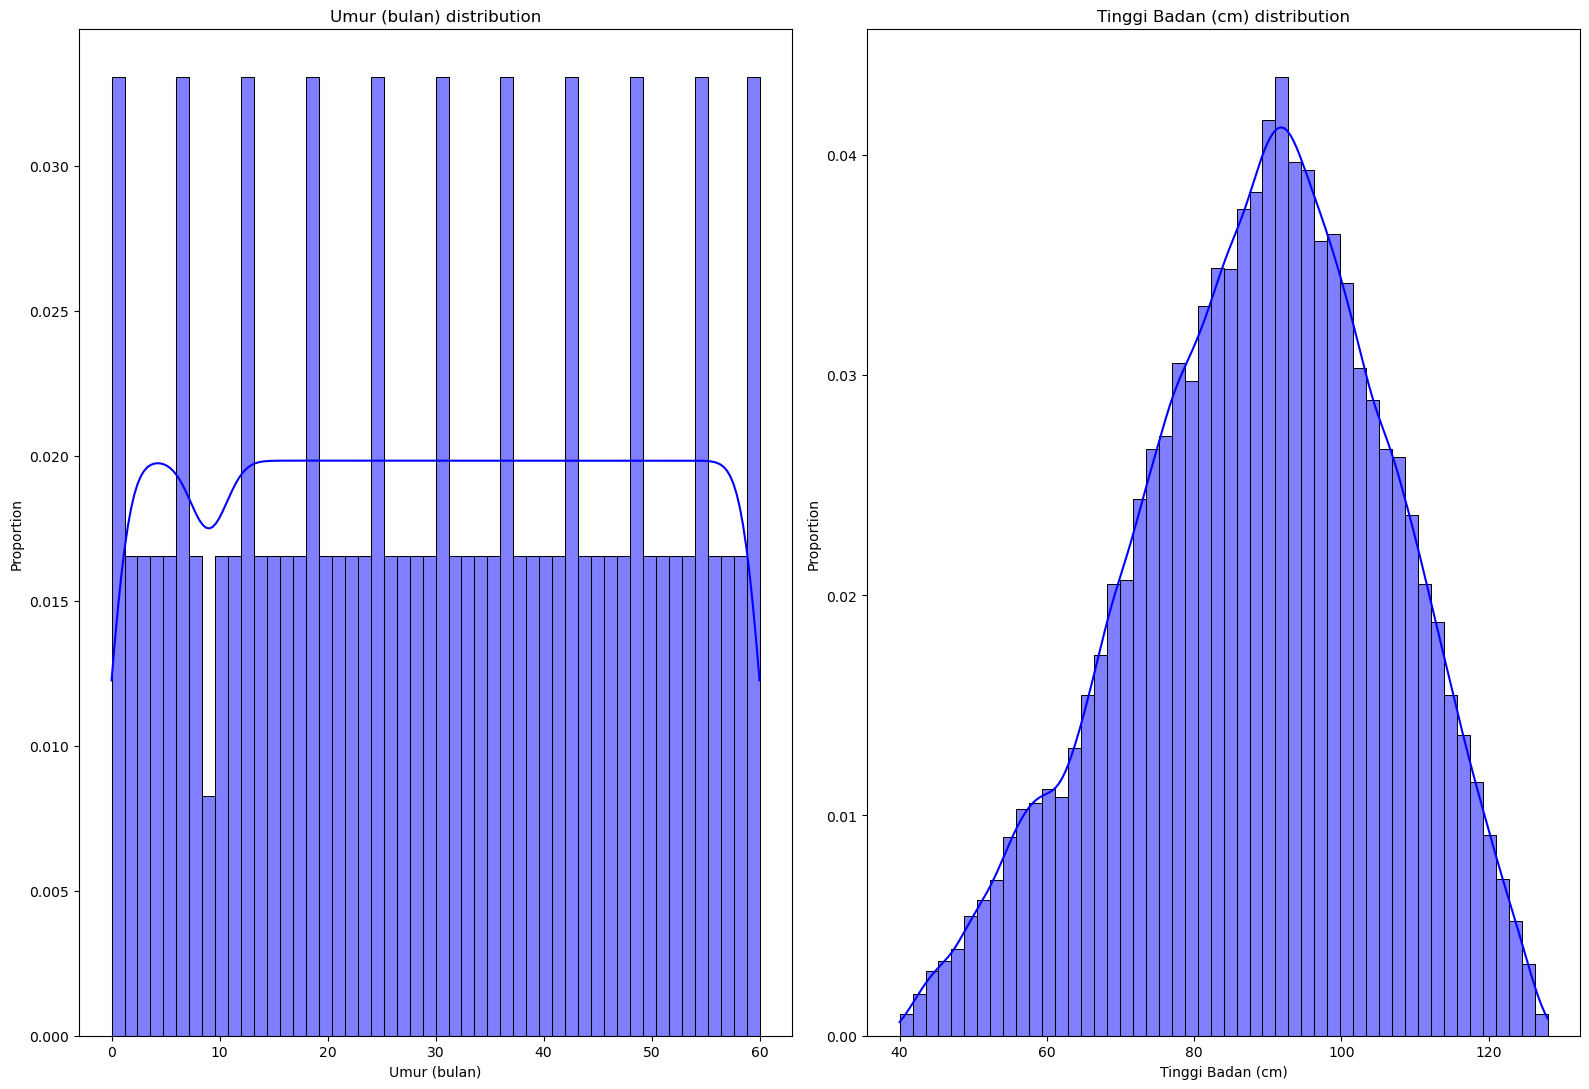

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


num_features = ["Umur (bulan)", "Tinggi Badan (cm)"]

fig, axes = plt.subplots(1,2, figsize=(16,11))
for ax, feature in zip(axes.flat, num_features):
    sns.histplot(data[feature], bins=50, stat="proportion",kde=True, color='blue', ax=ax)
    ax.set_ylabel(f'Proportion')
    ax.set_title(f"{feature} distribution")

plt.tight_layout()

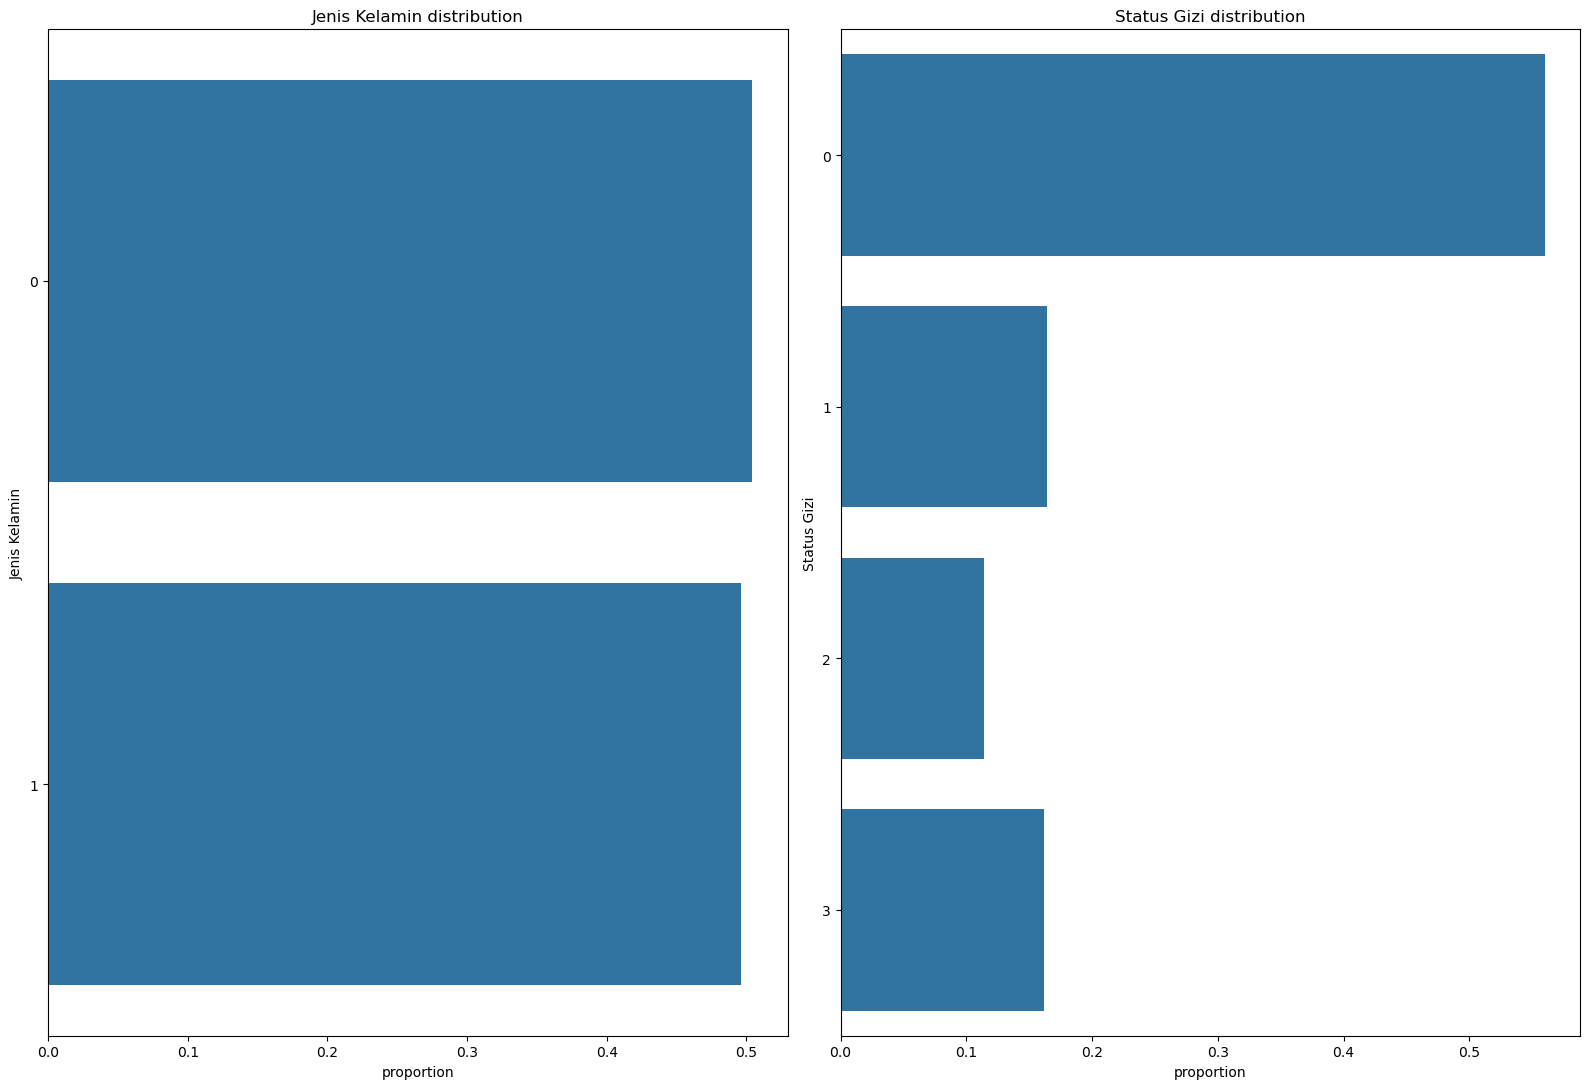

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 11))

cat_feature = ["Jenis Kelamin", "Status Gizi"]
for ax, feature in zip(axes.flat, cat_feature):
    vc = data[feature].value_counts(normalize=True)
    sns.barplot(x=vc.values,y=vc.index,ax=ax,orient='h')

    ax.set_xlabel("proportion")
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} distribution")



plt.tight_layout()
plt.show()

In [12]:
def check_outliers(data, features):
    outlier_counts = {}
    total_outlier = 0
    for feat in features:
        Q1 = data[feat].quantile(0.25)
        Q3 = data[feat].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_cound = Q3 + 1.5 * IQR
        feature_outlier = data[(data[feat] < lower_bound) | (data[feat] > upper_cound)]
        outlier_count = len(feature_outlier)
        outlier_counts[feat] = outlier_count
        total_outlier += outlier_count
    print(f"There are {total_outlier} outliers in the dataset")
    print()
    print("Outlier Percentage Per feature")
    for feature, count in outlier_counts.items():
        print(f"{feature}: {count} ({round(count/len(data)*100,2)})%")

In [13]:
data.columns

Index(['Umur (bulan)', 'Jenis Kelamin', 'Tinggi Badan (cm)', 'Status Gizi'], dtype='object')

In [14]:
check_outliers(data, ['Umur (bulan)','Tinggi Badan (cm)'])

There are 38 outliers in the dataset

Outlier Percentage Per feature
Umur (bulan): 0 (0.0)%
Tinggi Badan (cm): 38 (0.03)%


In [15]:
X = data.drop(columns=['Status Gizi'])
y = data['Status Gizi']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [16]:
data

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,0,1,44.591973,2
1,0,1,56.705203,3
2,0,1,46.863358,0
3,0,1,47.508026,0
4,0,1,42.743494,1
...,...,...,...,...
120994,60,0,100.600000,0
120995,60,0,98.300000,2
120996,60,0,121.300000,0
120997,60,0,112.200000,0


In [17]:

linear_models = {
                'Logistic Regression': LogisticRegression(),
                # 'Linear SVC': LinearSVC(),
                'KNN': KNeighborsClassifier(),
                }


# K-fold cross validation for linear models.
eval_df = classification_kfold_cv(models=linear_models, 
                                  X_train=X_train, 
                                  y_train=y_train, 
                                  n_folds=5)

# plot_classification_kfold_cv(eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

eval_df

Logistic Regression results: 
--------------------------------------------------
Training score: 0.641423136629139
Average validation score: 0.5973993890958726
Standard deviation: 0.019814389607049194
Training time: 1.54071 seconds

KNN results: 
--------------------------------------------------
Training score: 0.9999586181896754
Average validation score: 0.9993904743146291
Standard deviation: 0.00013970523900861783
Training time: 0.05043 seconds



,model,avg_val_score,train_score
0,KNN,0.999390,0.999959
1,Logistic Regression,0.597399,0.641423


Decision Tree results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.9953465208712051
Standard deviation: 0.0007952093144482702
Training time: 0.10605 seconds

Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.9999737890443974
Standard deviation: 5.678956044678452e-06
Training time: 2.88547 seconds

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 96799, number of used features: 3
[LightGBM] [Info] Start training from score -0.579882
[LightGBM] [Info] Start training from score -1.806632
[LightGBM] [Info] Start training 

,model,avg_val_score,train_score
0,Random Forest,0.999974,1.000000
1,LightGBM,0.998130,0.998953
2,Decision Tree,0.995347,1.000000


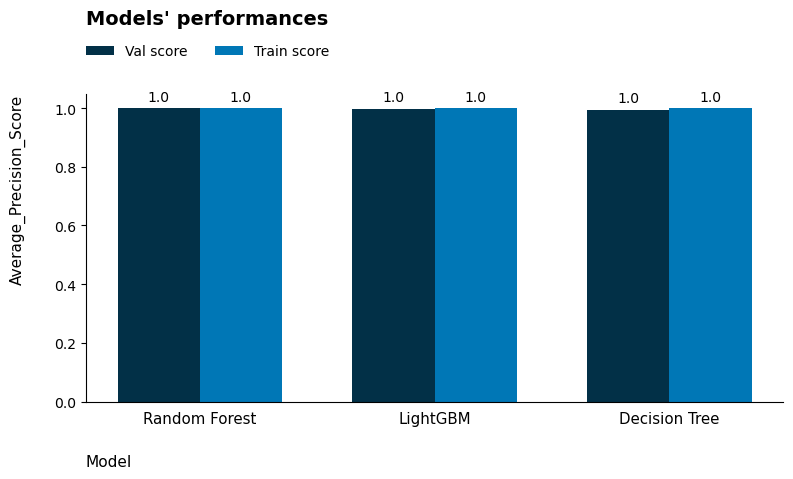

In [18]:
tree_models = {
              'Decision Tree': DecisionTreeClassifier(),
              'Random Forest': RandomForestClassifier(),
              'LightGBM': LGBMClassifier()
              }

tree_eval_df = classification_kfold_cv(models=tree_models, 
                                  X_train=X_train, 
                                  y_train=y_train, 
                                  n_folds=5)

plot_classification_kfold_cv(tree_eval_df, bar_width=0.35, figsize=(9, 4), title_size=14, legend_x=0.175, legend_y=1.2, title_pad=50)

tree_eval_df

In [19]:
lgb_clf = LGBMClassifier()
lgb_clf.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 96799, number of used features: 3
[LightGBM] [Info] Start training from score -0.579882
[LightGBM] [Info] Start training from score -1.806632
[LightGBM] [Info] Start training from score -2.170025
[LightGBM] [Info] Start training from score -1.822294


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     13551
           1       0.99      0.99      0.99      3974
           2       0.96      0.97      0.97      2763
           3       0.99      0.99      0.99      3912

    accuracy                           0.99     24200
   macro avg       0.98      0.99      0.99     24200
weighted avg       0.99      0.99      0.99     24200



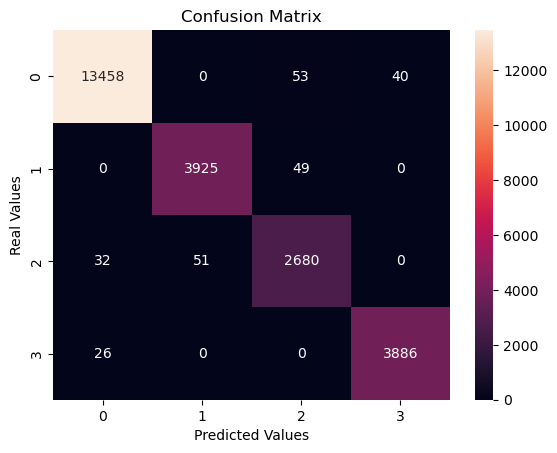

In [20]:
y_pred = lgb_clf.predict(X_test)
y_probas = lgb_clf.predict_proba(X_test.values)
model_metrics = evaluate_classifier(y_test, y_pred, y_probas)